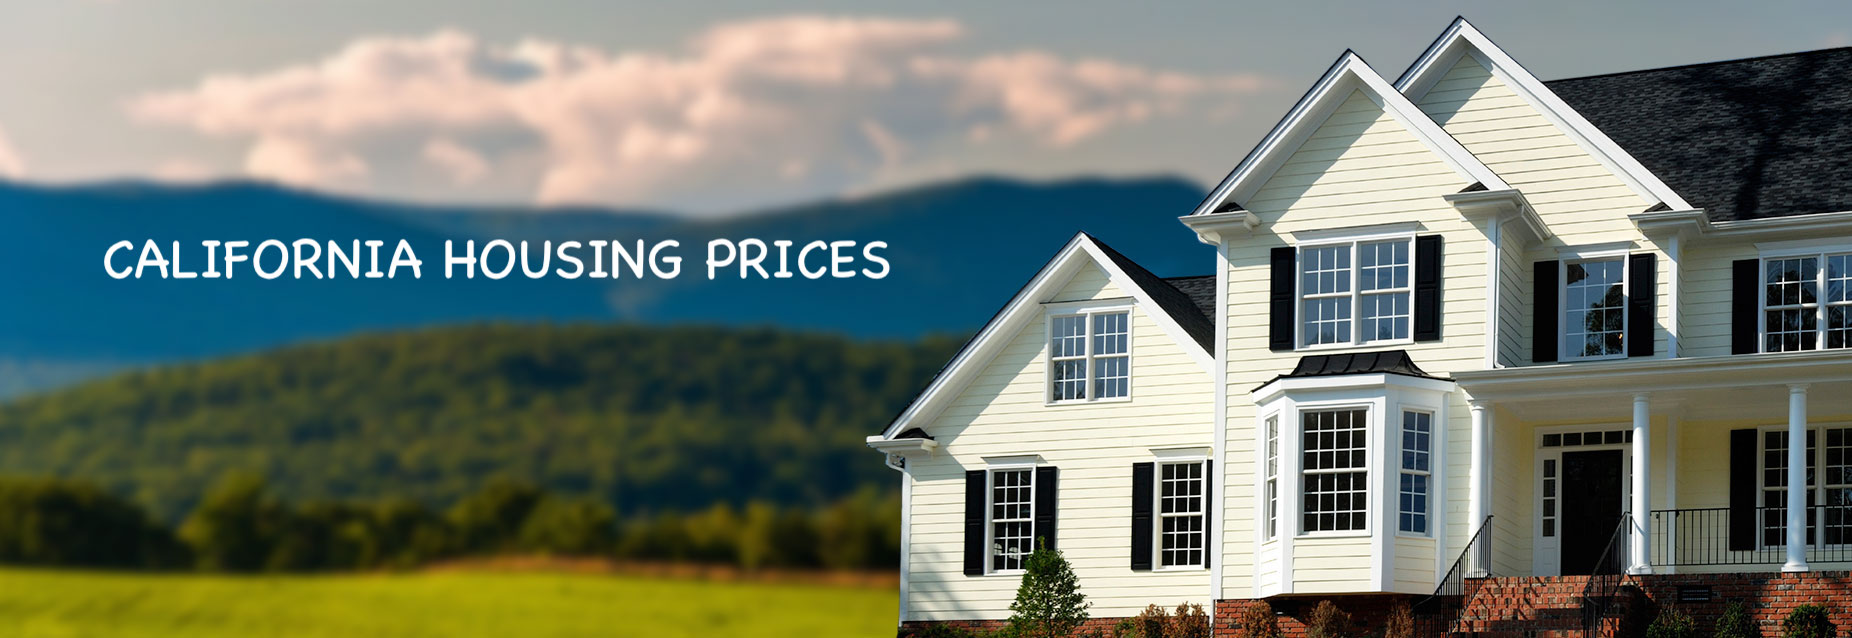

AUTHORS:   
- Abdulmalik Alrebdi 
- Saad AlOtaibi 
- Shaimaa Alghamdi 
- Sultan Alharbi

# Introduction

There is an investor who’s interested in houses and wants to have a general idea about houses price in California. 
He has a few questions such as: 

- The price of houses. 
- The suitable place to live.
- The suitable location of the houses with the fantastic view.


# Overview of the dataset

The data relates to the houses found in a given California district and some summary stats about them based on the 1990 census data. 

The observations of the dataset were described using 10 features as follows:

|Features |Description|
|-----|--------|
|Longitude|A measure of how far west a house is, a higher value is farther west |
|Latitude  |A measure of how far north a house is, a higher value is farther north  |
|housing_median_age  |Median age of a house within a block; a lower number is a newer building    |
|total_rooms  |Total number of rooms within a block     |
|Total_bedrooms  |Total number of bedrooms within a block |
|Population  |Total number of people residing within a block |
|Households  |Total number of households, a group of people residing within a home unit, for a block      |
|median_income  |Median income for households within a block of houses (measured in tens of thousands of US Dollars      |
|ocean_proximity  |Location of the house w.r.t ocean/sea  |
|median_house_value  |Median house value for households within a block (measured in US Dollars)      |



- Import 

In [5]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

- Read The dataset

# Exploratory Data Analysis (EDA)

In [ ]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.8,
s=df["median_house_value"]/10000, figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

Is the price related to the location?

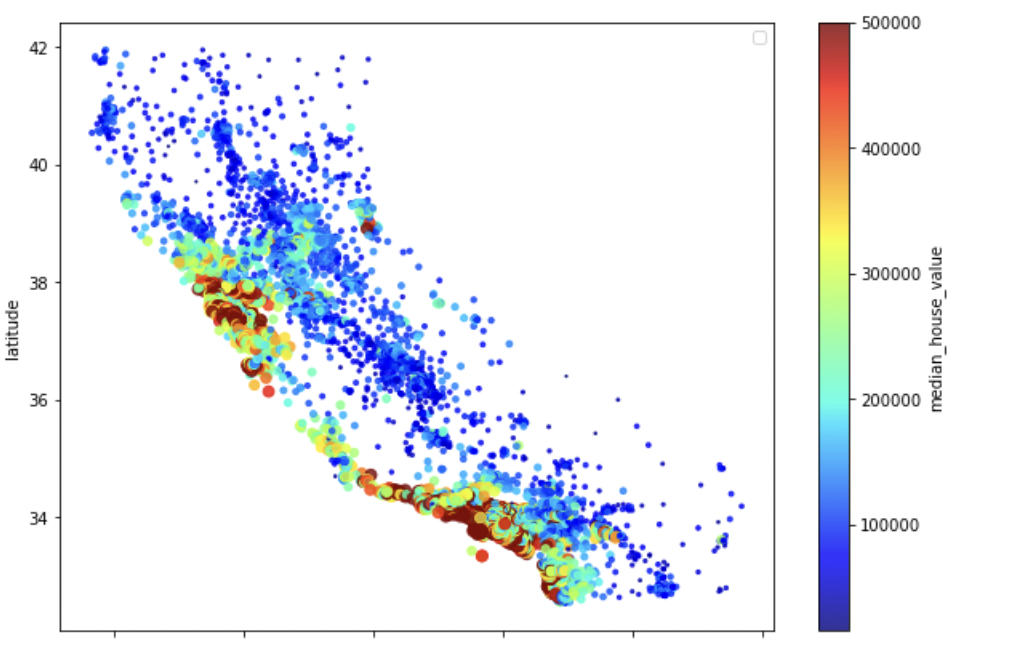

The locations of houses near the sea are considered the highest price.


What is the most common place to live?


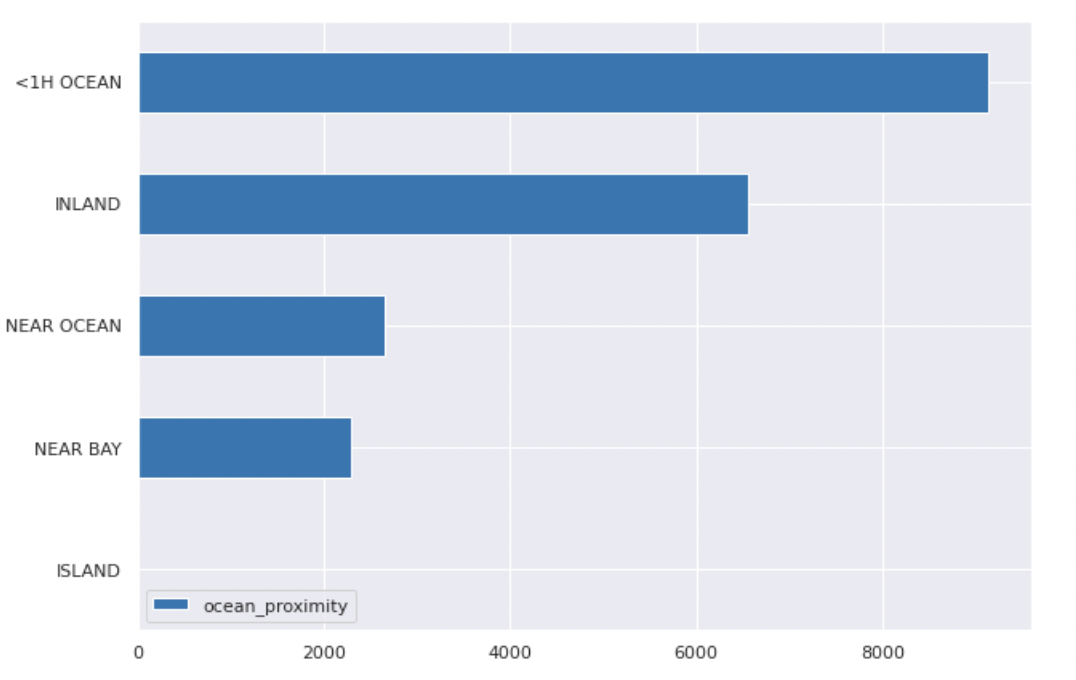

The population density is an hour away from the sea.


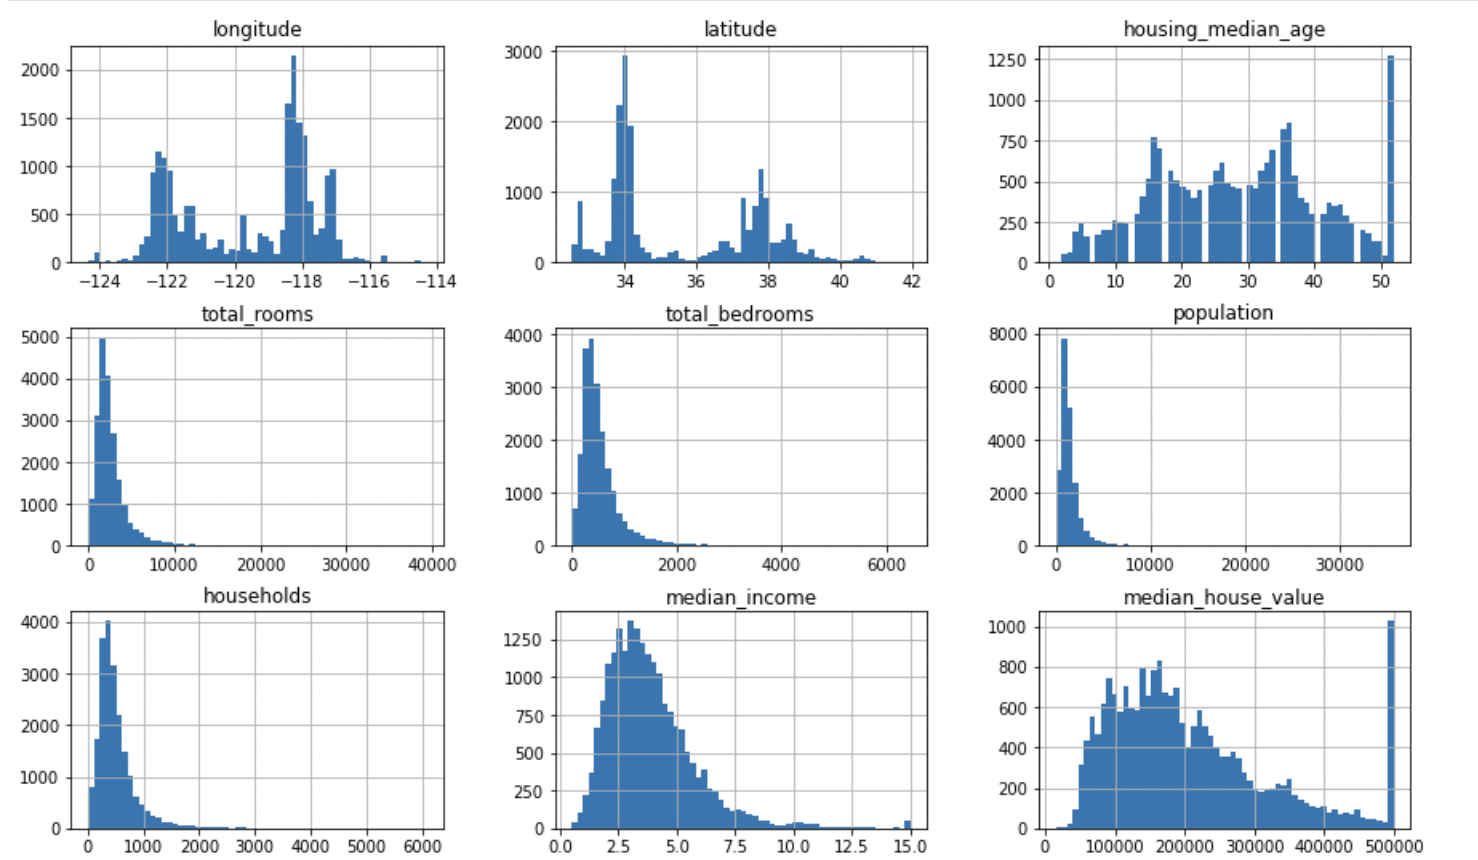

We notice that some of these features are right-side skewed
